# Visual Search Using Variational Autoeconders

In this notebook, we develop a prototype for unsupervised embedding learning using the variational autoencoder (VAE). We train the VAE on the Fashion MNIST dataset, and demonstrate it is capable of learning a smooth regular manifold. The embeddings obtained using VAE can be used for nearest neighbor search. 

This notebook is based on Tim Sainburg's implementation of VAE [1]. 

### Data 
We use the `Fashion MNIST` dataset. See `datasets.ms` for details.

### References
[1] https://github.com/timsainb/tensorflow2-generative-models

In [1]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
ds = tfp.distributions

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

# print("Keras version " + tf.keras.__version__)
# print("Tensorflow version " + tf.__version__)

# Load Data: Fashion MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

TRAIN_BUF = 60000
BATCH_SIZE = 512
DIMS = (28, 28, 1)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)

# split dataset
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

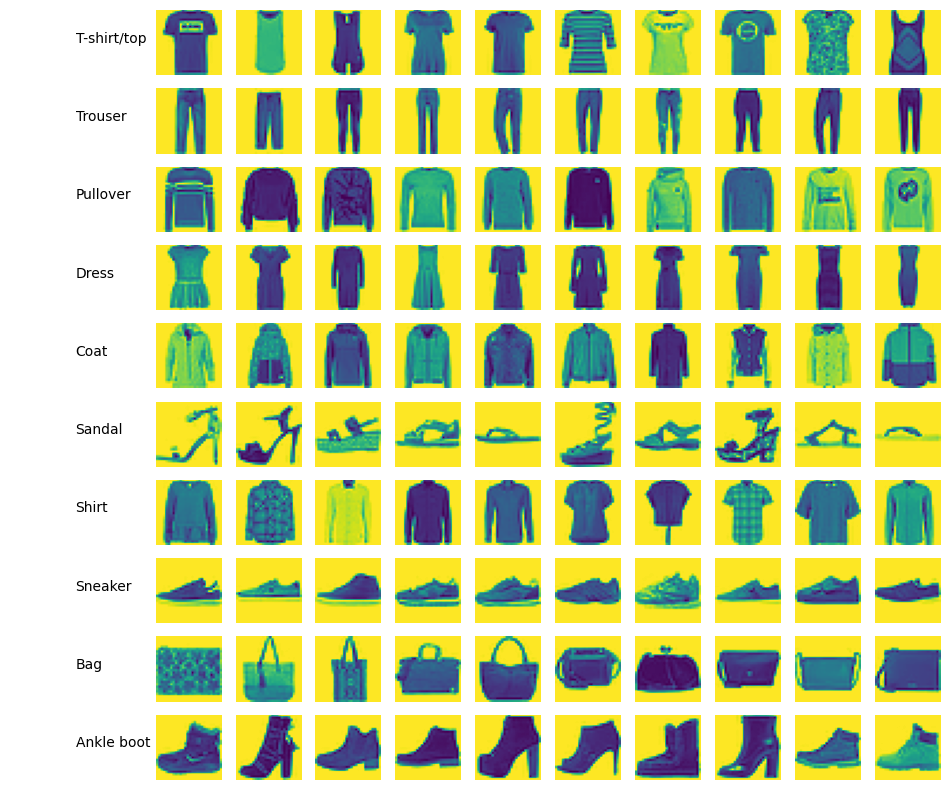

In [3]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

fig, ax = plt.subplots(10, 11, figsize=(12, 10), gridspec_kw={'width_ratios': [2] + [1]*10})
img_idx = 0
for i in range(10):
    ax[i, 0].axis('off')
    ax[i, 0].text(0.5, 0.5, fashion_mnist_labels[i])
    
    class_indexes = [k for k, n in enumerate(y_train) if n == i]
    for j in range(10):
        ax[i, j+1].imshow(1 - train_images[class_indexes[j], :])
        ax[i, j+1].axis('off')

# Variational Autoencoder Model

In [4]:
class VAE(tf.keras.Model):

    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)


    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            # Add any custom configuration parameters for your model here
            # For example, you can save the architecture of your encoder and decoder.
            'enc_config': tf.keras.layers.serialize(self.enc),
            'dec_config': tf.keras.layers.serialize(self.dec),
        })
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        if custom_objects is None:
            custom_objects = {}
        enc_config = config.pop('enc_config')
        dec_config = config.pop('dec_config')
        enc = tf.keras.layers.deserialize(enc_config, custom_objects=custom_objects)
        dec = tf.keras.layers.deserialize(dec_config, custom_objects=custom_objects)
        return cls(enc=enc, dec=dec, **config)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        
        
N_Z = 2
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

#
# Model training
#
optimizer = tf.keras.optimizers.Adam(1e-3)
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

n_epochs = 50
for epoch in range(n_epochs):
    print(f'Epoch {epoch}...')
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model.train(train_x)

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...
Epoch 26...
Epoch 27...
Epoch 28...
Epoch 29...
Epoch 30...
Epoch 31...
Epoch 32...
Epoch 33...
Epoch 34...
Epoch 35...
Epoch 36...
Epoch 37...
Epoch 38...
Epoch 39...
Epoch 40...
Epoch 41...
Epoch 42...
Epoch 43...
Epoch 44...
Epoch 45...
Epoch 46...
Epoch 47...
Epoch 48...
Epoch 49...


# Manifold Visualization

(-0.5, 279.5, 279.5, -0.5)

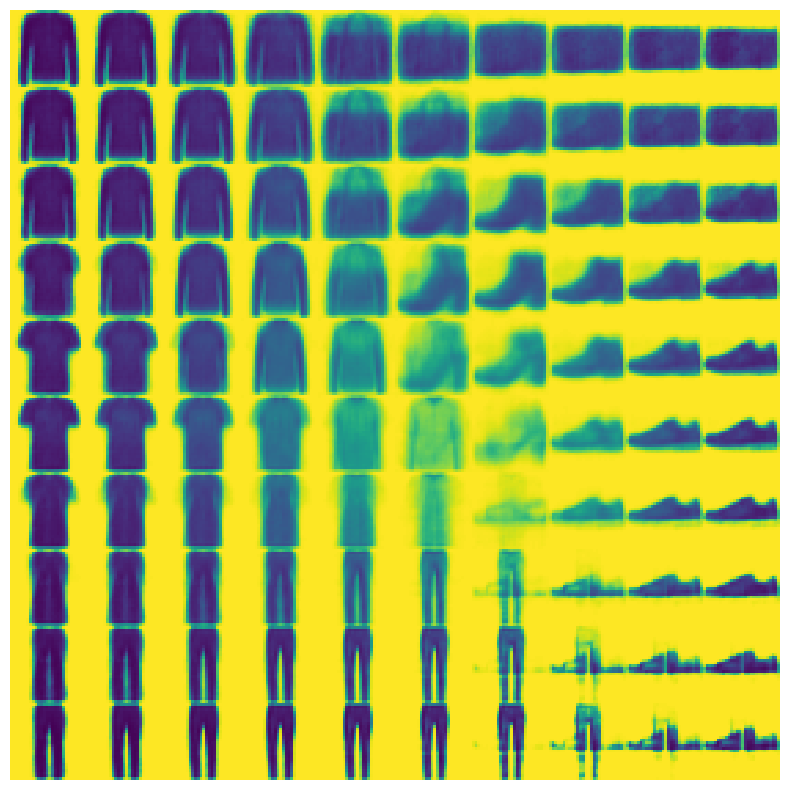

In [5]:
#
# Create a grid over the semantic space
#
nx = ny = 10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T

#
# Decode the points of the semantic space into images 
#
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)

#
# Visualize the reconstructed images
#
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28 : xi*28+28,  yi*28 : yi*28+28] = x_grid[xi, yi, :, :, :].squeeze()
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(1 - canvas)
ax.axis('off')

# Query Nearest Neighbors

In [6]:
embeddigns, _ = tf.split(model.enc(train_images), num_or_size_splits=2, axis=1)

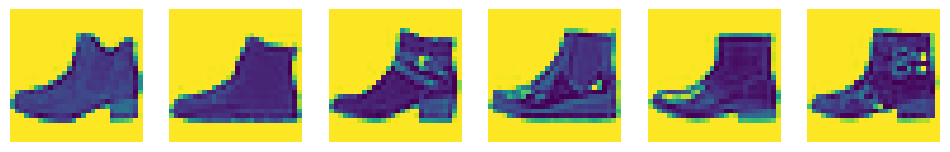

In [7]:
query_image_id = 15
k = 6


def query(image_id, k):
    query_embedding = embeddigns[image_id]
    distances = np.zeros(len(embeddigns))
    for i, e in enumerate(embeddigns):
        distances[i] = np.linalg.norm(query_embedding - e)
    return np.argpartition(distances, k)[:k]

idx = query(query_image_id, k=k)

fig, ax = plt.subplots(1, k, figsize=(k*2, 2))
for i in range(k):
    ax[i].imshow(1 - train_images[idx[i], :])
    ax[i].axis('off')
    
plt.savefig('query-example-2.pdf')

In [8]:
model.save('visual_search_vae.keras')

In [9]:
tf.keras.models.save_model(model,'visual_search_vae.keras')
